# Data Quality Handling for MagnusWeb Dataset

In [ ]:
import polars as pl
import os

# Path to curated panel file
curated_path = os.path.join("..", "data", "source_cleaned", "magnusweb_panel_with_margins.parquet")

# Load the curated panel
panel = pl.read_parquet(curated_path)
print(f"Loaded panel shape: {panel.shape}")
#panel.head()

time_series_cols = ['year', 'profit_pre_tax', 'total_liabilities_and_equity', 'oper_profit', 'total_assets', 'profit_net', 'sales_revenue', 'equity', 'turnover', 'costs']

calculated_cols = ["operating_margin_cal", "net_margin_cal", "roa_ebit_cal", "roe_cal", "equity_ratio_cal", "cost_ratio_cal", "effective_tax_rate_cal", "rev_growth_cal", "cost_growth_cal", "op_profit_growth_cal", "asset_turnover_cal", "labor_productivity_cal"]


Loaded panel shape: (1285104, 59)


In [2]:
# ============================================================================
# STEP 1: Dataset overview & basic sanity checks
# ============================================================================
import matplotlib.pyplot as plt
import numpy as np

print("=" * 80)
print("STEP 1: Dataset Overview & Basic Sanity Checks")
print("=" * 80)

# 1.1 Print schema, dtypes, row/column counts
print(f"\nDataset shape: {panel.shape}")
print(f"Columns ({len(panel.columns)}): {list(panel.columns)}")
print(f"\nData types summary (static):")
for col in panel.columns:
    if col not in time_series_cols and col not in calculated_cols:
        dtype = panel[col].dtype
        null_count = panel[col].null_count()
        non_null_count = panel[col].count()
        print(f"  {col:25s} | {str(dtype):15s} | non-null: {non_null_count:8,} | nulls: {null_count:8,}")

print(f"\nData types summary (time series):")
for col in time_series_cols:
    if col in panel.columns:
        dtype = panel[col].dtype
        null_count = panel[col].null_count()
        non_null_count = panel[col].count()
        print(f"  {col:25s} | {str(dtype):15s} | non-null: {non_null_count:8,} | nulls: {null_count:8,}")

print(f"\nData types summary (calculated):")
for col in calculated_cols:
    if col in panel.columns:
        dtype = panel[col].dtype
        null_count = panel[col].null_count()
        non_null_count = panel[col].count()
        print(f"  {col:25s} | {str(dtype):15s} | non-null: {non_null_count:8,} | nulls: {null_count:8,}")

# 1.2 Confirm time span
year_min = panel["year"].min()
year_max = panel["year"].max()
print(f"\nTime span: {year_min} to {year_max}")
assert year_min == 2000, f"Expected min year 2000, got {year_min}"
assert year_max == 2023, f"Expected max year 2023, got {year_max}"
print("Time span confirmed: 2000-2023")

# 1.3 Show unique firms and years-per-firm distribution
unique_firms = panel["ico"].n_unique()
print(f"\nNumber of unique firms (ICOs): {unique_firms:,}")

# Calculate years per firm
years_per_firm = panel.group_by("ico").agg(
    pl.col("year").count().alias("years_count")
)
years_distribution = years_per_firm["years_count"].value_counts().sort("years_count")
print(f"\nYears-per-firm distribution:")
for row in years_distribution.iter_rows():
    years, count = row
    print(f"  {years:2d} years: {count:8,} firms ({count/unique_firms*100:5.1f}%)")

# given the data pull format, we expect all firms to have 24 years of data, so this is expected. 

print(f"\nDataset has {panel.shape[0]:,} observations from {unique_firms:,} firms over {year_max-year_min+1} years.")

STEP 1: Dataset Overview & Basic Sanity Checks

Dataset shape: (1285104, 59)
Columns (59): ['ico', 'year', 'other_liabilities', 'costs', 'sales_revenue', 'equity', 'profit_net', 'turnover', 'current_assets', 'oper_profit', 'total_liabilities', 'total_assets', 'total_liabilities_and_equity', 'profit_pre_tax', 'other_assets', 'fixed_assets', 'name', 'main_nace', 'main_nace_code', 'sub_nace_cz', 'sub_nace_cz_code', 'main_okec', 'main_okec_code', 'sub_okec', 'sub_okec_code', 'esa2010', 'esa95', 'locality', 'region', 'num_employees', 'num_employees_cat', 'turnover_cat', 'audit', 'consolidation', 'currency', 'date_founded', 'date_dissolved', 'status', 'legal_form', 'entity_type', 'year_founded', 'year_dissolved', 'is_dissolved', 'operating_margin_cal', 'net_margin_cal', 'roa_ebit_cal', 'roe_cal', 'equity_ratio_cal', 'cost_ratio_cal', 'effective_tax_rate_cal', 'rev_growth_cal', 'cost_growth_cal', 'op_profit_growth_cal', 'asset_turnover_cal', 'labor_productivity_cal', 'level1_code', 'level2_co

In [3]:
# ============================================================================
# STEP 2: Drop non-existent firm-years (create unbalanced panel)
# ============================================================================
print("\n" + "=" * 80)
print("STEP 3: Drop Non-Existent Firm-Years")
print("=" * 80)

print(f" Starting shape: {panel.shape}")
print(f" Starting unique firms: {panel['ico'].n_unique():,}")

# 3.1 Check for year_founded and year_dissolved columns
founded_col = "year_founded"
dissolved_col = "year_dissolved"

# Apply date-based filtering if columns exist
initial_shape = panel.shape

if founded_col and founded_col in panel.columns:
    before_founded = panel.shape[0]
    panel = panel.filter(
        pl.col("year") >= pl.col(founded_col).fill_null(1900)
    )
    
    after_founded = panel.shape[0]
    print(f"Removed {before_founded - after_founded:,} rows where year < year_founded")

if dissolved_col and dissolved_col in panel.columns:
    before_dissolved = panel.shape[0]
    panel = panel.filter(
        (pl.col(dissolved_col).is_null()) | (pl.col("year") <= pl.col(dissolved_col))
    )
    after_dissolved = panel.shape[0]
    print(f"Removed {before_dissolved - after_dissolved:,} rows where year > year_dissolved")

# 3.2 Drop rows where ALL time-series financial fields are NULL
key_financial_cols = ['profit_pre_tax', 'total_liabilities_and_equity', 'oper_profit', 'total_assets', 'profit_net', 'sales_revenue', 'equity', 'turnover', 'costs']
print(f"\n Checking for rows with all key financial fields NULL...")

# Create a condition where ALL key fields are null
all_null_condition = pl.all_horizontal([pl.col(col).is_null() for col in key_financial_cols if col in panel.columns])

before_null_filter = panel.shape[0]
null_rows_count = panel.filter(all_null_condition).shape[0]
panel = panel.filter(~all_null_condition)
after_null_filter = panel.shape[0]

print(f" Removed {null_rows_count:,} rows where all time-series financial fields were NULL")

# 3.3 Require each firm to have ≥ 2 reporting years
print(f"\n🔍 Filtering for firms with ≥ 2 reporting years...")

# Count years per firm
firm_year_counts = panel.group_by("ico").agg(
    pl.col("year").count().alias("year_count")
)

# Firms with ≥ 2 years
firms_2plus_years = firm_year_counts.filter(pl.col("year_count") >= 2)["ico"]

before_min_years = panel.shape[0]
singleton_firms = panel["ico"].n_unique() - firms_2plus_years.len()
# Fix deprecation warning
firms_2plus_years_list = firms_2plus_years.to_list()
panel = panel.filter(pl.col("ico").is_in(firms_2plus_years_list))
after_min_years = panel.shape[0]

print(f"📉 Removed {singleton_firms:,} singleton firms")
print(f"📉 Removed {before_min_years - after_min_years:,} rows from singleton firms")

# 3.4 Print before/after summary
total_removed_rows = initial_shape[0] - panel.shape[0]
total_removed_firms = 53546 - panel["ico"].n_unique()  # Using the initial count from Step 1

print(f"\n📊 Step 3 Summary:")
print(f"  Initial: {initial_shape[0]:,} rows, {53546:,} firms")
print(f"  Final: {panel.shape[0]:,} rows, {panel['ico'].n_unique():,} firms")
print(f"  Removed: {total_removed_rows:,} rows ({total_removed_rows/initial_shape[0]*100:.1f}%)")
print(f"  Removed: {total_removed_firms:,} firms ({total_removed_firms/53546*100:.1f}%)")

print(f"\n✅ Step 3 complete. Created unbalanced panel with viable firm-years only.")


STEP 3: Drop Non-Existent Firm-Years
 Starting shape: (1285104, 59)
 Starting unique firms: 53,546
Removed 269,992 rows where year < year_founded
Removed 68,016 rows where year > year_dissolved

 Checking for rows with all key financial fields NULL...
 Removed 267,437 rows where all time-series financial fields were NULL

🔍 Filtering for firms with ≥ 2 reporting years...
📉 Removed 753 singleton firms
📉 Removed 753 rows from singleton firms

📊 Step 3 Summary:
  Initial: 1,285,104 rows, 53,546 firms
  Final: 678,906 rows, 50,777 firms
  Removed: 606,198 rows (47.2%)
  Removed: 2,769 firms (5.2%)

✅ Step 3 complete. Created unbalanced panel with viable firm-years only.


In [4]:
# ============================================================================
# STEP 4: Filter obvious impossibilities
# ============================================================================
print("\n" + "=" * 80)
print("STEP 4: Filter Obvious Impossibilities")
print("=" * 80)

print(f"📊 Starting shape: {panel.shape}")

# Define economic rules and check violations
initial_rows = panel.shape[0]

# Rule 1: sales_revenue ≥ 0 (where not null)
negative_revenue = panel.filter(
    (pl.col("sales_revenue") < 0) & pl.col("sales_revenue").is_not_null()
).shape[0]

# Rule 2: total_assets ≥ 0 (where not null)  
negative_assets = panel.filter(
    (pl.col("total_assets") < 0) & pl.col("total_assets").is_not_null()
).shape[0]

# Rule 3: total_assets == 0 (firms cannot operate with zero assets)
zero_assets = panel.filter(
    pl.col("total_assets") == 0
).shape[0]

print(f"\n🚨 Economic rule violations found:")
print(f"  Negative sales_revenue: {negative_revenue:,} rows")
print(f"  Negative total_assets: {negative_assets:,} rows") 
print(f"  Zero total_assets: {zero_assets:,} rows")

# Apply filters
print(f"\n🔧 Applying economic filters...")

# Filter 1: Remove negative sales_revenue
panel = panel.filter(
    (pl.col("sales_revenue") >= 0) | pl.col("sales_revenue").is_null()
)

# Filter 2: Remove negative total_assets
panel = panel.filter(
    (pl.col("total_assets") >= 0) | pl.col("total_assets").is_null()
)

# Filter 3: Remove zero total_assets
panel = panel.filter(
    (pl.col("total_assets") > 0) | pl.col("total_assets").is_null()
)

final_rows = panel.shape[0]
removed_rows = initial_rows - final_rows

print(f"\n📉 Economic filtering results:")
print(f"  Removed rows: {removed_rows:,} ({removed_rows/initial_rows*100:.2f}%)")
print(f"  Remaining rows: {final_rows:,}")
print(f"  Remaining firms: {panel['ico'].n_unique():,}")

# Additional sanity checks
print(f"\n🔍 Post-filter sanity checks:")
remaining_negative_revenue = panel.filter(
    (pl.col("sales_revenue") < 0) & pl.col("sales_revenue").is_not_null()
).shape[0]
remaining_negative_assets = panel.filter(
    (pl.col("total_assets") <= 0) & pl.col("total_assets").is_not_null()
).shape[0]

print(f"  Remaining negative sales_revenue: {remaining_negative_revenue}")
print(f"  Remaining non-positive total_assets: {remaining_negative_assets}")

assert remaining_negative_revenue == 0, "Should have no negative revenue"
assert remaining_negative_assets == 0, "Should have no non-positive assets"

print(f"\n✅ Step 4 complete. Removed {removed_rows:,} rows violating economic rules.")


STEP 4: Filter Obvious Impossibilities
📊 Starting shape: (678906, 59)

🚨 Economic rule violations found:
  Negative sales_revenue: 217 rows
  Negative total_assets: 185 rows
  Zero total_assets: 1,111 rows

🔧 Applying economic filters...

📉 Economic filtering results:
  Removed rows: 1,506 (0.22%)
  Remaining rows: 677,400
  Remaining firms: 50,767

🔍 Post-filter sanity checks:
  Remaining negative sales_revenue: 0
  Remaining non-positive total_assets: 0

✅ Step 4 complete. Removed 1,506 rows violating economic rules.


In [5]:
# ============================================================================
# STEP 5: Compute/verify core ratios
# ============================================================================
print("\n" + "=" * 80)
print("STEP 5: Compute/Verify Core Ratios") 
print("=" * 80)

print(f"Starting shape: {panel.shape}")

# 5.1 Identify rows with zero sales_revenue 
zero_revenue_count = panel.filter(pl.col("sales_revenue") == 0).shape[0]
null_revenue_count = panel.filter(pl.col("sales_revenue").is_null()).shape[0]
positive_revenue_count = panel.filter(pl.col("sales_revenue") > 0).shape[0]

print(f"\n Sales revenue breakdown:")
print(f"  Zero sales_revenue: {zero_revenue_count:,} rows")
print(f"  Null sales_revenue: {null_revenue_count:,} rows") 
print(f"  Positive sales_revenue: {positive_revenue_count:,} rows")

# 5.2 Re-compute operating_margin_cal (overwrite existing)
print(f"\n Re-computing operating_margin_cal...")

# Count how many will get a calculated margin
valid_for_op_margin = panel.filter(
    pl.col("oper_profit").is_not_null() & 
    pl.col("sales_revenue").is_not_null() & 
    (pl.col("sales_revenue") > 0)
).shape[0]

print(f"  Rows with valid data for operating margin: {valid_for_op_margin:,}")

panel = panel.with_columns([
    pl.when(
        pl.col("oper_profit").is_not_null() & 
        pl.col("sales_revenue").is_not_null() & 
        (pl.col("sales_revenue") > 0)
    )
    .then(pl.col("oper_profit") / pl.col("sales_revenue"))
    .otherwise(None)
    .alias("operating_margin_cal")
])

# 5.3 Re-compute cost_ratio_cal
print(f"\n🔧 Re-computing cost_ratio_cal...")

valid_for_cost_ratio = panel.filter(
    pl.col("costs").is_not_null() & 
    pl.col("sales_revenue").is_not_null() & 
    (pl.col("sales_revenue") > 0)
).shape[0]

print(f"  Rows with valid data for cost ratio: {valid_for_cost_ratio:,}")

panel = panel.with_columns([
    pl.when(
        pl.col("costs").is_not_null() & 
        pl.col("sales_revenue").is_not_null() & 
        (pl.col("sales_revenue") > 0)
    )
    .then(pl.col("costs") / pl.col("sales_revenue"))
    .otherwise(None)
    .alias("cost_ratio_cal")
])

# 5.4 Check the computed ratios
print(f"\n Ratio calculation results:")

op_margin_stats = panel.select([
    pl.col("operating_margin_cal").count().alias("count"),
    pl.col("operating_margin_cal").mean().alias("mean"),
    pl.col("operating_margin_cal").median().alias("median"),
    pl.col("operating_margin_cal").std().alias("std"),
    pl.col("operating_margin_cal").min().alias("min"),
    pl.col("operating_margin_cal").max().alias("max"),
])

cost_ratio_stats = panel.select([
    pl.col("cost_ratio_cal").count().alias("count"),
    pl.col("cost_ratio_cal").mean().alias("mean"),
    pl.col("cost_ratio_cal").median().alias("median"),
    pl.col("cost_ratio_cal").std().alias("std"),
    pl.col("cost_ratio_cal").min().alias("min"),
    pl.col("cost_ratio_cal").max().alias("max"),
])

print(f"\n Operating margin statistics:")
for row in op_margin_stats.iter_rows(named=True):
    for key, value in row.items():
        if key == "count":
            print(f"  {key}: {value:,}")
        else:
            print(f"  {key}: {value:.4f}")

print(f"\n Cost ratio statistics:")
for row in cost_ratio_stats.iter_rows(named=True):
    for key, value in row.items():
        if key == "count":
            print(f"  {key}: {value:,}")
        else:
            print(f"  {key}: {value:.4f}")

# 5.5 Remove rows with zero sales_revenue (Fix 2)
zero_sales_count = panel.filter(pl.col("sales_revenue") == 0).shape[0]
print(f"\n Removing {zero_sales_count:,} rows with zero sales_revenue...")

# Move zero-sales rows to parking table for potential future analysis
zero_sales_tbl = panel.filter(pl.col("sales_revenue") == 0)
panel = panel.filter((pl.col("sales_revenue") != 0) | pl.col("sales_revenue").is_null())

print(f" Zero-sales rows moved to separate table for future study")
print(f" Remaining panel shape: {panel.shape}")



STEP 5: Compute/Verify Core Ratios
Starting shape: (677400, 59)

 Sales revenue breakdown:
  Zero sales_revenue: 14,053 rows
  Null sales_revenue: 60,451 rows
  Positive sales_revenue: 602,896 rows

 Re-computing operating_margin_cal...
  Rows with valid data for operating margin: 597,924

🔧 Re-computing cost_ratio_cal...
  Rows with valid data for cost ratio: 602,618

 Ratio calculation results:

 Operating margin statistics:
  count: 597,924
  mean: -1.7598
  median: 0.0379
  std: 566.0718
  min: -387832.5000
  max: 58152.0000

 Cost ratio statistics:
  count: 602,618
  mean: 26.6748
  median: 1.0000
  std: 14165.8337
  min: -3564.5000
  max: 10956870.0000

 Removing 14,053 rows with zero sales_revenue...
 Zero-sales rows moved to separate table for future study
 Remaining panel shape: (663347, 59)


In [6]:
# ============================================================================
# STEP 6: Winsorise extreme ratios (robust outlier handling)
# ============================================================================
print("\n" + "=" * 80)
print("STEP 6: Winsorise Extreme Ratios")
print("=" * 80)

# Define the ratios to winsorise
ratios_to_winsorise = ["operating_margin_cal", "cost_ratio_cal"]

# Check if net_margin_cal exists and clean it
if "net_margin_cal" in panel.columns:
    # Fix 1: Replace inf/-inf with None before winsorisation
    panel = panel.with_columns([
        pl.col("net_margin_cal").replace([float('inf'), float('-inf')], None).alias("net_margin_cal")
    ])
    ratios_to_winsorise.append("net_margin_cal")

print(f"🎯 Ratios to winsorise: {ratios_to_winsorise}")

# Function to get quantiles and winsorise
def winsorise_ratio(df, col_name, lower_q=0.005, upper_q=0.995):
    """Winsorise a ratio column at specified quantiles."""
    # Preserve raw column
    df = df.with_columns([pl.col(col_name).alias(f"{col_name}_raw")])

    # Special handling for cost_ratio_cal: floor at 0
    if col_name == "cost_ratio_cal":
        df = df.with_columns([
            pl.when(pl.col(col_name) < 0)
            .then(0.0)
            .otherwise(pl.col(col_name))
            .alias(col_name)
        ])
        lower_bound = 0.0
        # Quantiles calculated *after* negative values are floored to zero
        quantiles = df.select([
            pl.col(col_name).quantile(upper_q).alias("upper_bound"),
            pl.col(col_name).min().alias("original_min"),
            pl.col(col_name).max().alias("original_max"),
            pl.col(col_name).count().alias("count")
        ]).to_dicts()[0]
        upper_bound = quantiles["upper_bound"]
        original_min = quantiles["original_min"]
        original_max = quantiles["original_max"]
        count = quantiles["count"]
    else:
        # For other ratios: standard winsorisation
        quantiles = df.select([
            pl.col(col_name).quantile(lower_q).alias("lower_bound"),
            pl.col(col_name).quantile(upper_q).alias("upper_bound"),
            pl.col(col_name).min().alias("original_min"),
            pl.col(col_name).max().alias("original_max"),
            pl.col(col_name).count().alias("count")
        ]).to_dicts()[0]
        lower_bound = quantiles["lower_bound"]
        upper_bound = quantiles["upper_bound"]
        original_min = quantiles["original_min"]
        original_max = quantiles["original_max"]
        count = quantiles["count"]

    # Apply winsorisation (for cost_ratio_cal: floor at 0, upper at quantile)
    if col_name == "cost_ratio_cal":
        # All <0 already set to 0
        df = df.with_columns([
            pl.when(pl.col(col_name).is_not_null())
            .then(pl.col(col_name).clip(lower_bound, upper_bound))
            .otherwise(None)
            .alias(col_name)
        ])
        extreme_low = df.filter(pl.col(f"{col_name}_raw") < 0).shape[0]
        extreme_high = df.filter(pl.col(f"{col_name}_raw") > upper_bound).shape[0]
    else:
        df = df.with_columns([
            pl.when(pl.col(col_name).is_not_null())
            .then(pl.col(col_name).clip(lower_bound, upper_bound))
            .otherwise(None)
            .alias(col_name)
        ])
        extreme_low = df.filter(pl.col(f"{col_name}_raw") < lower_bound).shape[0]
        extreme_high = df.filter(pl.col(f"{col_name}_raw") > upper_bound).shape[0]

    # Print diagnostics
    print(f"\n📊 {col_name} winsorisation:")
    print(f"  Valid observations: {count:,}")
    print(f"  Original range: [{original_min:.4f}, {original_max:.4f}]")
    print(f"  Winsorisation bounds: [{lower_bound:.4f}, {upper_bound:.4f}]")
    print(f"  Values clipped low: {extreme_low:,} ({extreme_low/count*100:.2f}%)")
    print(f"  Values clipped high: {extreme_high:,} ({extreme_high/count*100:.2f}%)")
    return df, (lower_bound, upper_bound)

# Apply winsorisation to each ratio
winsorisation_bounds = {}

for ratio in ratios_to_winsorise:
    if ratio in panel.columns:
        panel, bounds = winsorise_ratio(panel, ratio)
        winsorisation_bounds[ratio] = bounds
    else:
        print(f"⚠️  Column {ratio} not found, skipping...")

# Verify winsorisation worked
print(f"\n🔍 Post-winsorisation verification:")
for ratio in ratios_to_winsorise:
    if ratio in panel.columns:
        post_stats = panel.select([
            pl.col(ratio).min().alias("min"),
            pl.col(ratio).max().alias("max"),
            pl.col(ratio).mean().alias("mean"),
            pl.col(ratio).median().alias("median"),
            pl.col(ratio).std().alias("std")
        ]).to_dicts()[0]
        
        print(f"  {ratio}:")
        print(f"    Range: [{post_stats['min']:.4f}, {post_stats['max']:.4f}]")
        print(f"    Mean: {post_stats['mean']:.4f}, Median: {post_stats['median']:.4f}")

print(f"\n✅ Step 6 complete. Applied winsorisation to {len([b for b in winsorisation_bounds.values() if b[0] is not None])} ratios.")


STEP 6: Winsorise Extreme Ratios
🎯 Ratios to winsorise: ['operating_margin_cal', 'cost_ratio_cal', 'net_margin_cal']

📊 operating_margin_cal winsorisation:
  Valid observations: 597,924
  Original range: [-387832.5000, 58152.0000]
  Winsorisation bounds: [-3.6717, 0.7471]
  Values clipped low: 2,990 (0.50%)
  Values clipped high: 2,990 (0.50%)

📊 cost_ratio_cal winsorisation:
  Valid observations: 602,618
  Original range: [0.0000, 10956870.0000]
  Winsorisation bounds: [0.0000, 18.0042]
  Values clipped low: 104 (0.02%)
  Values clipped high: 3,013 (0.50%)

📊 net_margin_cal winsorisation:
  Valid observations: 601,588
  Original range: [-104677.0000, 105431.5000]
  Winsorisation bounds: [-3.4559, 0.8921]
  Values clipped low: 3,008 (0.50%)
  Values clipped high: 3,008 (0.50%)

🔍 Post-winsorisation verification:
  operating_margin_cal:
    Range: [-3.6717, 0.7471]
    Mean: 0.0194, Median: 0.0379
  cost_ratio_cal:
    Range: [0.0000, 18.0042]
    Mean: 1.2271, Median: 1.0000
  net_mar

In [7]:
# ============================================================================
# STEP 7: Balance-sheet consistency check
# ============================================================================
print("\n" + "=" * 80)
print("STEP 7: Balance-Sheet Consistency Check")
print("=" * 80)

print(f"📊 Starting shape: {panel.shape}")

# 7.1 Check if we have both sides of the balance sheet
assets_col = "total_assets"
liab_equity_col = "total_liabilities_and_equity"

if assets_col not in panel.columns:
    print(f"⚠️  {assets_col} column not found")
if liab_equity_col not in panel.columns:
    print(f"⚠️  {liab_equity_col} column not found")

if assets_col in panel.columns and liab_equity_col in panel.columns:
    # Count rows where both sides are available
    both_sides_available = panel.filter(
        pl.col(assets_col).is_not_null() & 
        pl.col(liab_equity_col).is_not_null() &
        (pl.col(assets_col) > 0) & 
        (pl.col(liab_equity_col) > 0)
    )
    
    print(f"🔍 Balance sheet data availability:")
    print(f"  Rows with both assets and liabilities+equity: {both_sides_available.shape[0]:,}")
    
    if both_sides_available.shape[0] > 0:
        # Calculate percentage gap
        balance_check = both_sides_available.with_columns([
            (pl.col(assets_col) - pl.col(liab_equity_col)).abs().alias("abs_diff"),
            ((pl.col(assets_col) - pl.col(liab_equity_col)).abs() / pl.col(assets_col) * 100).alias("pct_gap")
        ])
        
        # Summary statistics of the gap
        gap_stats = balance_check.select([
            pl.col("pct_gap").count().alias("count"),
            pl.col("pct_gap").mean().alias("mean_gap"),
            pl.col("pct_gap").median().alias("median_gap"),
            pl.col("pct_gap").std().alias("std_gap"),
            pl.col("pct_gap").min().alias("min_gap"),
            pl.col("pct_gap").max().alias("max_gap"),
            pl.col("pct_gap").quantile(0.95).alias("p95_gap"),
            pl.col("pct_gap").quantile(0.99).alias("p99_gap")
        ]).to_dicts()[0]
        
        print(f"\n📈 Balance sheet gap statistics (%):")
        for key, value in gap_stats.items():
            if key == "count":
                print(f"  {key}: {value:,}")
            else:
                print(f"  {key}: {value:.2f}%")
        
        # Count observations with gap > 25%
        large_gaps = balance_check.filter(pl.col("pct_gap") > 25).shape[0]
        print(f"\n🚨 Observations with gap > 25%: {large_gaps:,} ({large_gaps/balance_check.shape[0]*100:.2f}%)")
        
        # Apply filter: drop observations with gap > 25% (Fix 3: Safer approach)
        if large_gaps > 0:
            print(f"\n🔧 Removing {large_gaps:,} observations with balance sheet gaps > 25%...")
            
            # Use boolean filter instead of join to preserve rows with missing data
            large_gap_condition = balance_check.filter(pl.col("pct_gap") > 25).select(["ico", "year"])
            
            # Remove only the large gap rows, keep everything else including partial data
            before_bs_filter = panel.shape[0]
            panel = panel.join(large_gap_condition, on=["ico", "year"], how="anti")
            after_bs_filter = panel.shape[0]
            
            removed_bs = before_bs_filter - after_bs_filter
            print(f"📉 Removed {removed_bs:,} rows due to balance sheet inconsistencies")
            print(f"📊 Preserved rows with partial balance sheet data")
        else:
            print("✅ No observations with large balance sheet gaps found")
            
        # Final gap summary for retained observations
        final_balance_check = panel.filter(
            pl.col(assets_col).is_not_null() & 
            pl.col(liab_equity_col).is_not_null() &
            (pl.col(assets_col) > 0) & 
            (pl.col(liab_equity_col) > 0)
        ).with_columns([
            ((pl.col(assets_col) - pl.col(liab_equity_col)).abs() / pl.col(assets_col) * 100).alias("pct_gap")
        ])
        
        if final_balance_check.shape[0] > 0:
            final_gap_stats = final_balance_check.select([
                pl.col("pct_gap").mean().alias("mean_gap"),
                pl.col("pct_gap").median().alias("median_gap"),
                pl.col("pct_gap").max().alias("max_gap")
            ]).to_dicts()[0]
            
            print(f"\n📊 Retained observations balance sheet gap summary:")
            print(f"  Mean gap: {final_gap_stats['mean_gap']:.2f}%")
            print(f"  Median gap: {final_gap_stats['median_gap']:.2f}%") 
            print(f"  Max gap: {final_gap_stats['max_gap']:.2f}%")
    else:
        print("⚠️  No observations have both assets and liabilities+equity data")
else:
    print("⚠️  Cannot perform balance sheet consistency check - missing required columns")

print(f"\n📊 Final shape after balance sheet check: {panel.shape}")
print(f"📊 Remaining firms: {panel['ico'].n_unique():,}")

print(f"\n✅ Step 7 complete. Balance sheet consistency verified and enforced.")


STEP 7: Balance-Sheet Consistency Check
📊 Starting shape: (663347, 62)
🔍 Balance sheet data availability:
  Rows with both assets and liabilities+equity: 662,195

📈 Balance sheet gap statistics (%):
  count: 662,195
  mean_gap: 0.34%
  median_gap: 0.00%
  std_gap: 144.58%
  min_gap: 0.00%
  max_gap: 99936.53%
  p95_gap: 0.00%
  p99_gap: 0.00%

🚨 Observations with gap > 25%: 158 (0.02%)

🔧 Removing 158 observations with balance sheet gaps > 25%...
📉 Removed 158 rows due to balance sheet inconsistencies
📊 Preserved rows with partial balance sheet data

📊 Retained observations balance sheet gap summary:
  Mean gap: 0.00%
  Median gap: 0.00%
  Max gap: 24.93%

📊 Final shape after balance sheet check: (663189, 62)
📊 Remaining firms: 50,650

✅ Step 7 complete. Balance sheet consistency verified and enforced.



STEP 8: Visual Diagnostics
📊 Creating operating margin histogram...
📊 Creating time-series of median operating margin...
📊 Creating sector distribution chart...
📊 Creating cost ratio histogram...


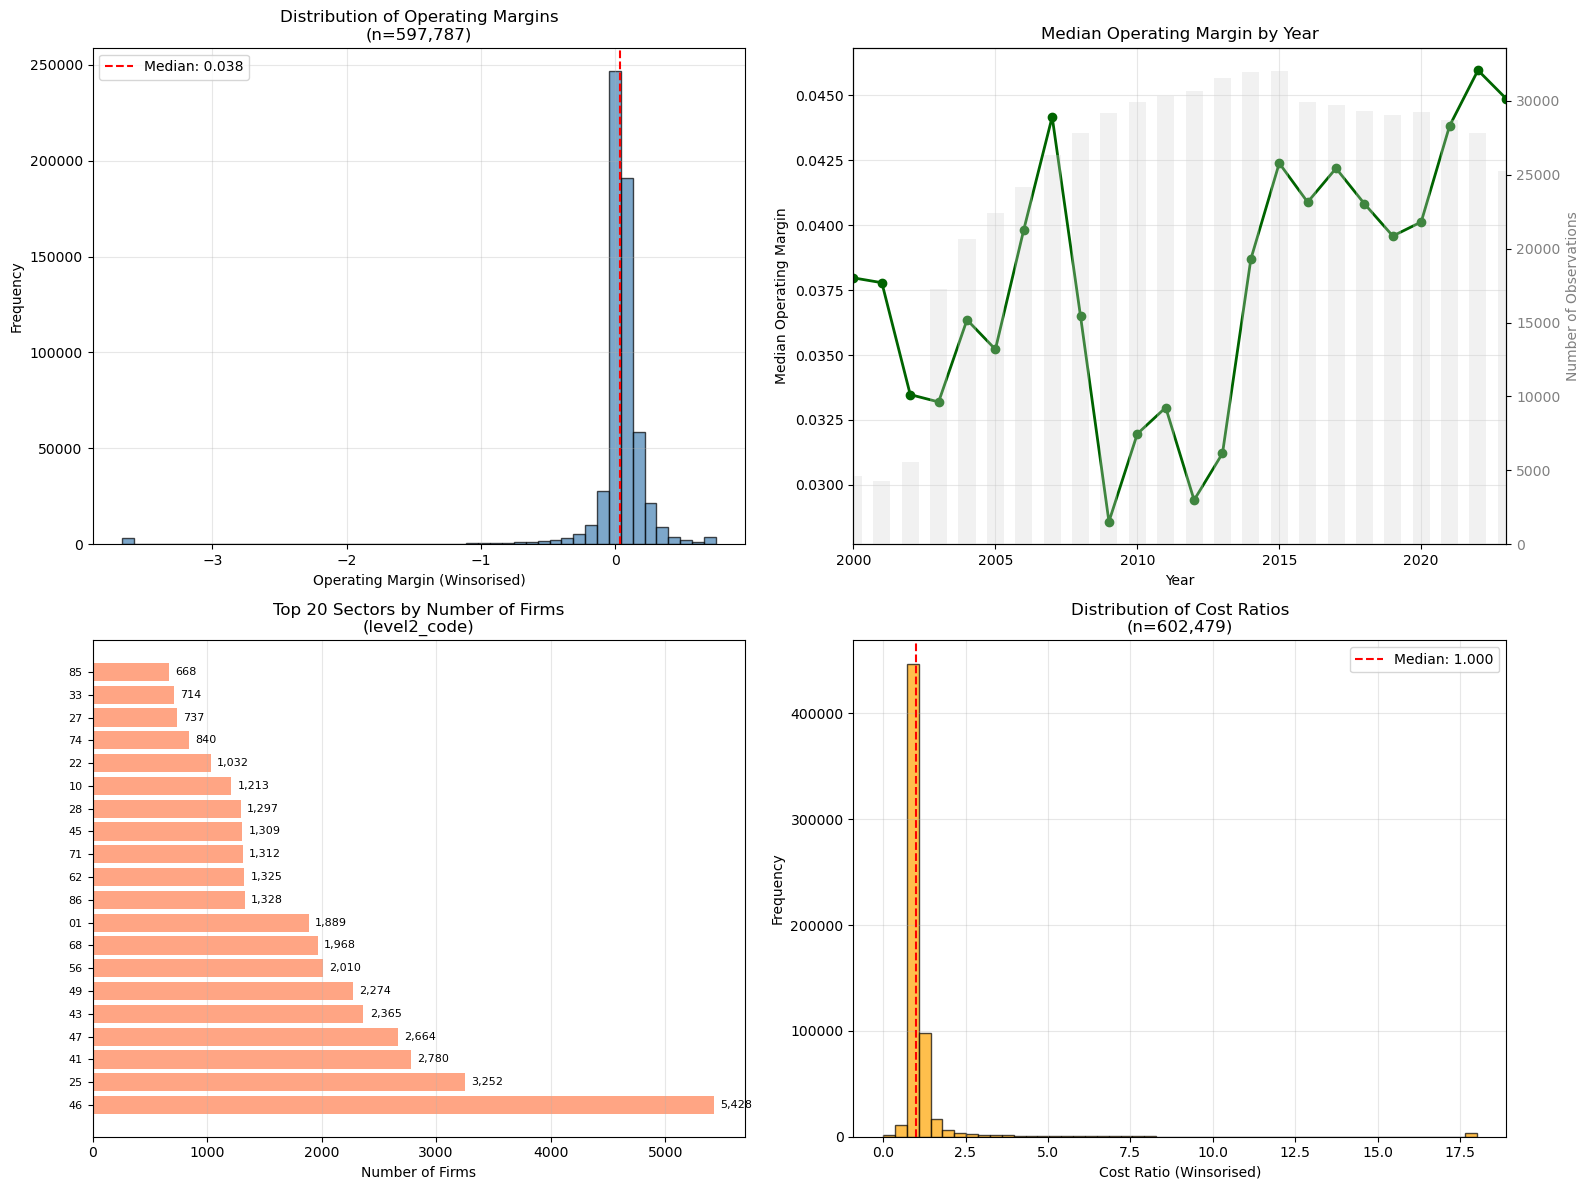


📈 Visual diagnostics summary:
  Operating margin observations: 597,787
  Operating margin median: 0.0379
  Years with data: 24 (2000-2023)
  Top sector by firm count: 46 (5,428 firms)
  Cost ratio observations: 602,479
  Cost ratio median: 1.0000

✅ Step 8 complete. Visual diagnostics generated successfully.


In [8]:
# ============================================================================
# STEP 8: Visual diagnostics (before saving)
# ============================================================================
print("\n" + "=" * 80)
print("STEP 8: Visual Diagnostics")
print("=" * 80)

# Create figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 8.1 Histogram of operating_margin_cal after winsorisation
print("📊 Creating operating margin histogram...")
op_margins = panel.filter(pl.col("operating_margin_cal").is_not_null())["operating_margin_cal"].to_numpy()

ax1.hist(op_margins, bins=50, alpha=0.7, edgecolor='black', color='steelblue')
ax1.set_xlabel('Operating Margin (Winsorised)')
ax1.set_ylabel('Frequency')
ax1.set_title(f'Distribution of Operating Margins\n(n={len(op_margins):,})')
ax1.grid(True, alpha=0.3)
ax1.axvline(np.median(op_margins), color='red', linestyle='--', 
           label=f'Median: {np.median(op_margins):.3f}')
ax1.legend()

# 8.2 Time-series of median operating margin by year
print("📊 Creating time-series of median operating margin...")
margin_by_year = panel.filter(
    pl.col("operating_margin_cal").is_not_null()
).group_by("year").agg([
    pl.col("operating_margin_cal").median().alias("median_margin"),
    pl.col("operating_margin_cal").count().alias("count")
]).sort("year")

years = margin_by_year["year"].to_numpy()
median_margins = margin_by_year["median_margin"].to_numpy()
counts = margin_by_year["count"].to_numpy()

ax2.plot(years, median_margins, marker='o', linewidth=2, markersize=6, color='darkgreen')
ax2.set_xlabel('Year')
ax2.set_ylabel('Median Operating Margin')
ax2.set_title('Median Operating Margin by Year')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(2000, 2023)

# Add secondary y-axis for count
ax2_twin = ax2.twinx()
ax2_twin.bar(years, counts, alpha=0.3, color='lightgray', width=0.6)
ax2_twin.set_ylabel('Number of Observations', color='gray')
ax2_twin.tick_params(axis='y', labelcolor='gray')

# 8.3 Bar chart: number of firms per level2_code sector (top 20)
print("📊 Creating sector distribution chart...")
if "level2_code" in panel.columns:
    sector_counts = panel.group_by("level2_code").agg([
        pl.col("ico").n_unique().alias("firm_count")
    ]).filter(
        pl.col("level2_code").is_not_null()
    ).sort("firm_count", descending=True).limit(20)
    
    sectors = sector_counts["level2_code"].to_list()
    firm_counts = sector_counts["firm_count"].to_list()
    
    # Create horizontal bar chart for better readability
    y_pos = np.arange(len(sectors))
    bars = ax3.barh(y_pos, firm_counts, color='coral', alpha=0.7)
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(sectors, fontsize=8)
    ax3.set_xlabel('Number of Firms')
    ax3.set_title('Top 20 Sectors by Number of Firms\n(level2_code)')
    ax3.grid(True, alpha=0.3, axis='x')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax3.text(width + 0.01*max(firm_counts), bar.get_y() + bar.get_height()/2, 
                f'{int(width):,}', ha='left', va='center', fontsize=8)
else:
    ax3.text(0.5, 0.5, 'level2_code column not available', 
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Sector Distribution Not Available')

# 8.4 Additional diagnostic: Cost ratio distribution
print("📊 Creating cost ratio histogram...")
if "cost_ratio_cal" in panel.columns:
    cost_ratios = panel.filter(pl.col("cost_ratio_cal").is_not_null())["cost_ratio_cal"].to_numpy()
    
    ax4.hist(cost_ratios, bins=50, alpha=0.7, edgecolor='black', color='orange')
    ax4.set_xlabel('Cost Ratio (Winsorised)')
    ax4.set_ylabel('Frequency')
    ax4.set_title(f'Distribution of Cost Ratios\n(n={len(cost_ratios):,})')
    ax4.grid(True, alpha=0.3)
    ax4.axvline(np.median(cost_ratios), color='red', linestyle='--', 
               label=f'Median: {np.median(cost_ratios):.3f}')
    ax4.legend()
else:
    ax4.text(0.5, 0.5, 'cost_ratio_cal column not available', 
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Cost Ratio Distribution Not Available')

plt.tight_layout()
plt.show()

# Print summary statistics for the plots
print(f"\n📈 Visual diagnostics summary:")
print(f"  Operating margin observations: {len(op_margins):,}")
print(f"  Operating margin median: {np.median(op_margins):.4f}")
print(f"  Years with data: {len(years)} ({min(years)}-{max(years)})")

if "level2_code" in panel.columns and len(sectors) > 0:
    print(f"  Top sector by firm count: {sectors[0]} ({firm_counts[0]:,} firms)")

if "cost_ratio_cal" in panel.columns:
    print(f"  Cost ratio observations: {len(cost_ratios):,}")
    print(f"  Cost ratio median: {np.median(cost_ratios):.4f}")

print(f"\n✅ Step 8 complete. Visual diagnostics generated successfully.")

In [9]:
# ============================================================================
# STEP 9: Save cleaned datasets
# ============================================================================
print("\n" + "=" * 80)
print("STEP 9: Save Cleaned Datasets")
print("=" * 80)

# Define output paths
main_output_path = os.path.join("..", "data", "source_cleaned", "magnusweb_panel_cleaned.parquet")
hq_output_path = os.path.join("..", "data", "source_cleaned", "magnusweb_panel_more_than_8_years.parquet")

# 9.1 Save main cleaned panel
print(f"💾 Saving main cleaned panel...")
panel.write_parquet(main_output_path, compression="snappy")

main_firms = panel["ico"].n_unique()
main_shape = panel.shape

print(f"✅ Main panel saved to: {main_output_path}")
print(f"   Shape: {main_shape}")
print(f"   Unique firms: {main_firms:,}")

# 9.2 Create and save high-quality subset (≥8 years reporting)
print(f"\n💎 Creating high-quality subset (firms with ≥8 years reporting)...")

# Count reporting years per firm
firm_reporting_years = panel.group_by("ico").agg([
    pl.col("year").count().alias("reporting_years")
])

# Get firms with ≥8 years
hq_firms = firm_reporting_years.filter(
    pl.col("reporting_years") >= 8
)["ico"]

print(f"🔍 Firms with ≥8 reporting years: {hq_firms.len():,} out of {main_firms:,} ({hq_firms.len()/main_firms*100:.1f}%)")

# Create high-quality panel
# Fix deprecation warning
hq_firms_list = hq_firms.to_list()
hq_panel = panel.filter(pl.col("ico").is_in(hq_firms_list))

# # Save high-quality panel
# hq_panel.write_parquet(hq_output_path, compression="snappy")

hq_firms_final = hq_panel["ico"].n_unique()
hq_shape = hq_panel.shape

# print(f"✅ High-quality panel saved to: {hq_output_path}")
print(f"   Shape: {hq_shape}")
print(f"   Unique firms: {hq_firms_final:,}")

# 9.3 Summary comparison
print(f"\n📊 Dataset comparison:")
print(f"{'Dataset':<20} {'Observations':<12} {'Firms':<8} {'Avg Years/Firm':<15}")
print(f"{'-'*20:<20} {'-'*12:<12} {'-'*8:<8} {'-'*15:<15}")

main_avg_years = main_shape[0] / main_firms
hq_avg_years = hq_shape[0] / hq_firms_final

print(f"{'Main cleaned':<20} {main_shape[0]:<12,} {main_firms:<8,} {main_avg_years:<15.1f}")
print(f"{'High-quality':<20} {hq_shape[0]:<12,} {hq_firms_final:<8,} {hq_avg_years:<15.1f}")

# Additional statistics for the high-quality subset
hq_year_stats = hq_panel.group_by("ico").agg([
    pl.col("year").count().alias("years")
])["years"]

hq_min_years = hq_year_stats.min()
hq_max_years = hq_year_stats.max()
hq_median_years = hq_year_stats.median()

print(f"\n More than 8 years subset reporting years distribution:")
print(f"   Min years per firm: {hq_min_years}")
print(f"   Median years per firm: {hq_median_years}")
print(f"   Max years per firm: {hq_max_years}")

# Year coverage for both datasets
main_year_coverage = panel.group_by("year").agg([
    pl.col("ico").n_unique().alias("firms")
]).sort("year")

hq_year_coverage = hq_panel.group_by("year").agg([
    pl.col("ico").n_unique().alias("firms")
]).sort("year")

print(f"\n📅 Year coverage comparison (first 5 and last 5 years):")
print(f"{'Year':<6} {'Main':<8} {'HQ':<8} {'HQ %':<8}")
print(f"{'-'*6:<6} {'-'*8:<8} {'-'*8:<8} {'-'*8:<8}")

# Show first 5 years
for i in range(5):
    year = main_year_coverage["year"][i]
    main_firms_year = main_year_coverage["firms"][i]
    hq_firms_year = hq_year_coverage["firms"][i]
    hq_pct = (hq_firms_year / main_firms_year * 100) if main_firms_year > 0 else 0
    print(f"{year:<6} {main_firms_year:<8,} {hq_firms_year:<8,} {hq_pct:<8.1f}%")

print("  ...")

# Show last 5 years
for i in range(-5, 0):
    year = main_year_coverage["year"][i]
    main_firms_year = main_year_coverage["firms"][i]
    hq_firms_year = hq_year_coverage["firms"][i]
    hq_pct = (hq_firms_year / main_firms_year * 100) if main_firms_year > 0 else 0
    print(f"{year:<6} {main_firms_year:<8,} {hq_firms_year:<8,} {hq_pct:<8.1f}%")

print(f"\n✅ Step 9 complete. Both cleaned datasets saved successfully.")

# ============================================================================
# FINAL STATISTICS FOR SUMMARY (Fix 1 & 7)
# ============================================================================
print("\n" + "=" * 80)
print("Computing Final Statistics for Summary")
print("=" * 80)

# Recompute final winsorisation bounds after all filtering
final_winsorisation_bounds = {}
for ratio in ["operating_margin_cal", "cost_ratio_cal", "net_margin_cal"]:
    if ratio in panel.columns:
        bounds = panel.select([
            pl.col(ratio).quantile(0.005).alias("lower"),
            pl.col(ratio).quantile(0.995).alias("upper")
        ]).to_dicts()[0]
        
        if bounds["lower"] is not None and bounds["upper"] is not None:
            final_winsorisation_bounds[ratio] = (bounds["lower"], bounds["upper"])
            print(f"📊 Final {ratio} bounds: [{bounds['lower']:.4f}, {bounds['upper']:.4f}]")

# Compute final summary statistics
final_summary_stats = {
    "observations": panel.shape[0],
    "firms": panel["ico"].n_unique(),
    "avg_years_per_firm": panel.shape[0] / panel["ico"].n_unique(),
    "operating_margin_median": panel["operating_margin_cal"].median(),
    "cost_ratio_median": panel["cost_ratio_cal"].median(),
}

print(f"\n📋 Final dataset statistics:")
for key, value in final_summary_stats.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value:,}")

print(f"\n✅ Final statistics computed for summary section.")


STEP 9: Save Cleaned Datasets
💾 Saving main cleaned panel...
✅ Main panel saved to: ../data/source_cleaned/magnusweb_panel_cleaned.parquet
   Shape: (663189, 62)
   Unique firms: 50,650

💎 Creating high-quality subset (firms with ≥8 years reporting)...
🔍 Firms with ≥8 reporting years: 37,661 out of 50,650 (74.4%)
   Shape: (603774, 62)
   Unique firms: 37,661

📊 Dataset comparison:
Dataset              Observations Firms    Avg Years/Firm 
-------------------- ------------ -------- ---------------
Main cleaned         663,189      50,650   13.1           
High-quality         603,774      37,661   16.0           

 More than 8 years subset reporting years distribution:
   Min years per firm: 8
   Median years per firm: 17.0
   Max years per firm: 24

📅 Year coverage comparison (first 5 and last 5 years):
Year   Main     HQ       HQ %    
------ -------- -------- --------
2000   4,619    3,985    86.3    %
2001   4,519    3,903    86.4    %
2002   5,807    5,058    87.1    %
2003   18,

In [10]:
# ============================================================================
# Generate Dynamic Summary Text (Fix 7)
# ============================================================================

# Format winsorisation bounds for summary
op_margin_bounds = final_winsorisation_bounds.get('operating_margin_cal', (None, None))
cost_ratio_bounds = final_winsorisation_bounds.get('cost_ratio_cal', (None, None))
net_margin_bounds = final_winsorisation_bounds.get('net_margin_cal', (None, None))

op_margin_text = f"[{op_margin_bounds[0]:.4f}, {op_margin_bounds[1]:.4f}]" if op_margin_bounds[0] is not None else "Not available"
cost_ratio_text = f"[{cost_ratio_bounds[0]:.4f}, {cost_ratio_bounds[1]:.4f}]" if cost_ratio_bounds[0] is not None else "Not available"
net_margin_text = f"[{net_margin_bounds[0]:.4f}, {net_margin_bounds[1]:.4f}]" if net_margin_bounds[0] is not None else "Not available"

print("📋 Summary statistics ready for markdown cell:")
print(f"  Final observations: {final_summary_stats['observations']:,}")
print(f"  Final firms: {final_summary_stats['firms']:,}")
print(f"  Avg years per firm: {final_summary_stats['avg_years_per_firm']:.1f}")
print(f"  Operating margin median: {final_summary_stats['operating_margin_median']:.4f}")
print(f"  Cost ratio median: {final_summary_stats['cost_ratio_median']:.4f}")
print(f"  Operating margin bounds: {op_margin_text}")
print(f"  Cost ratio bounds: {cost_ratio_text}")
print(f"  Net margin bounds: {net_margin_text}")
if 'zero_sales_count' in locals():
    print(f"  Zero sales removed: {zero_sales_count:,}")
else:
    print("  Zero sales count: Not available")

📋 Summary statistics ready for markdown cell:
  Final observations: 663,189
  Final firms: 50,650
  Avg years per firm: 13.1
  Operating margin median: 0.0379
  Cost ratio median: 1.0000
  Operating margin bounds: [-3.6717, 0.7471]
  Cost ratio bounds: [0.5078, 18.0000]
  Net margin bounds: [-3.4559, 0.8921]
  Zero sales removed: 14,053


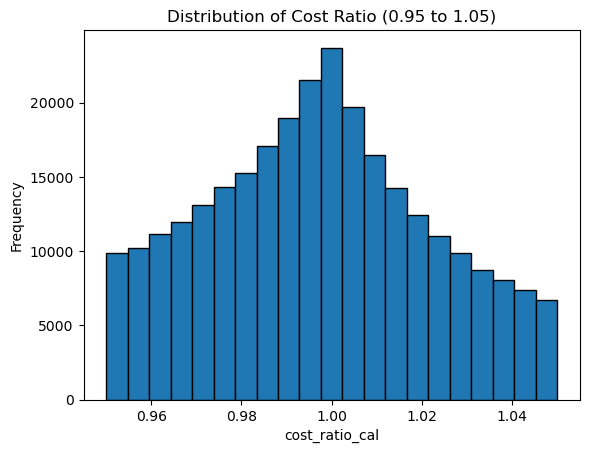

shape: (10, 2)
┌────────────────────┬───────┐
│ cost_ratio_rounded ┆ count │
│ ---                ┆ ---   │
│ f64                ┆ u32   │
╞════════════════════╪═══════╡
│ null               ┆ 60710 │
│ 1.0                ┆ 47206 │
│ 0.99               ┆ 39590 │
│ 1.01               ┆ 34341 │
│ 0.98               ┆ 31899 │
│ 0.97               ┆ 26811 │
│ 1.02               ┆ 25729 │
│ 0.96               ┆ 22553 │
│ 1.03               ┆ 19926 │
│ 0.95               ┆ 19588 │
└────────────────────┴───────┘
Share of cost_ratio_cal == 1: 0.09%
Share of firms ever reporting cost_ratio_cal == 1: 0.80%
Firms always reporting 1: 0.01%


In [11]:
import matplotlib.pyplot as plt

cost_ratios = panel.filter(
    pl.col("cost_ratio_cal").is_not_null() & 
    (pl.col("cost_ratio_cal") >= 0.95) & 
    (pl.col("cost_ratio_cal") <= 1.05)
)["cost_ratio_cal"].to_numpy()

plt.hist(cost_ratios, bins=21, edgecolor="black")
plt.title("Distribution of Cost Ratio (0.95 to 1.05)")
plt.xlabel("cost_ratio_cal")
plt.ylabel("Frequency")
plt.show()


import numpy as np
rounded = panel.with_columns([
    pl.col("cost_ratio_cal").round(2).alias("cost_ratio_rounded")
])
heap_counts = rounded["cost_ratio_rounded"].value_counts().sort("count", descending=True)
print(heap_counts.head(10))

# Fraction of cost_ratio_cal at 1.0 (all obs)
cost_ratio_one_obs = panel.filter(pl.col("cost_ratio_cal") == 1).shape[0]
cost_ratio_all_obs = panel.filter(pl.col("cost_ratio_cal").is_not_null()).shape[0]
print(f"Share of cost_ratio_cal == 1: {cost_ratio_one_obs / cost_ratio_all_obs * 100:.2f}%")

# Fraction of firms ever reporting cost_ratio_cal == 1
firms_with_one = panel.filter(pl.col("cost_ratio_cal") == 1)["ico"].n_unique()
all_firms = panel["ico"].n_unique()
print(f"Share of firms ever reporting cost_ratio_cal == 1: {firms_with_one / all_firms * 100:.2f}%")

# Fraction of firms ONLY reporting cost_ratio_cal == 1 (across all years)
firm_grouped = panel.group_by("ico").agg([
    pl.col("cost_ratio_cal").min().alias("min"),
    pl.col("cost_ratio_cal").max().alias("max"),
    pl.col("cost_ratio_cal").count().alias("n_obs")
])
always_one = firm_grouped.filter((pl.col("min") == 1) & (pl.col("max") == 1)).shape[0]
print(f"Firms always reporting 1: {always_one / all_firms * 100:.2f}%")
